In [33]:
from deepcrypto.backtest import *
from deepcrypto.portfolio_analysis import *
from deepcrypto.data_utils.crawlers.bitfinex_kaggle import *
from talib.abstract import *

In [40]:
def strategy(df, config):
    mean_volume = df["volume"].rolling(int(config["mean_volume_period"])).mean().shift(1)
    volume_signal = (df["volume"] / mean_volume) > config["volume_times"]
    
    returns = df["close"].pct_change(int(config["return_period"]))
    return_signal = ((returns == returns.rolling(int(config["return_signal_period"])).max()).rolling(int(config["any_return_period"])).max() == 1)
        
    breakout_signal = df["high"] > df["high"].rolling(int(config["time_cut"] // 2)).max().shift(1)
    breakout_signal_short = df["low"] < df["low"].rolling(int(config["time_cut"] // 2)).min().shift(1)
    
    ma = df["close"].rolling(int(config["ma_period"])).mean()
    ma_signal = ma.diff() > 0
    
    df["enter_long"] = return_signal & volume_signal & ma_signal & breakout_signal
    df["bet"] = np.clip(0.01 / df.close.pct_change().rolling(200).std(), 0.1, 2) * 2
    df["time_cut"] = config["time_cut"]
    df["stop_loss"] = config["stop_loss"] / df["bet"]
    df["take_profit"] = config["take_profit"]
    df["trade_cost"] = 0.001
    

    
    return df

In [35]:
def backtest(config, ticker):
    data = read_bitfinex_data("/home/ych/Storage/bitfinex/bitfinex.db", "1H", ticker)
    data = data.backtest.add_defaults()

    order, port = strategy(data, config).backtest()
    qs.reports.full(port["portfolio_value"].resample("1D").last(), benchmark=port["open"].resample("1D").last())

In [41]:
DEFAULT_CONFIG = {'return_signal_period': 24,
 'ma_period': 48,
 'mean_volume_period': 12,
 'return_period': 6,
 'any_return_period': 3,
 'time_cut': 24,
 'stop_loss': 0.05,
 'take_profit': 0.1,
 'volume_times': 3}

backtest completed in 0.05824446678161621 seconds


                           Strategy     Benchmark
-------------------------  -----------  -----------
Start Period               2016-03-18   2016-03-18
End Period                 2021-05-18   2021-05-18
Risk-Free Rate             0.0%         0.0%
Time in Market             30.0%        97.0%

Cumulative Return          831,900.19%  31,191.55%
CAGR%                      473.14%      203.87%

Sharpe                     1.99         1.31
Sortino                    4.85         2.07
Sortino/√2                 3.43         1.46

Max Drawdown               -40.12%      -93.85%
Longest DD Days            156          1101
Volatility (ann.)          72.79%       87.76%
R^2                        0.18         0.18
Calmar                     11.79        2.17
Skew                       3.37         0.38
Kurtosis                   19.22        5.56

Expected Daily %           0.48%        0.3%
Expected Monthly %         15.4%        9.55%
Expected Yearly %          350.15%      160.56%
Kelly Cr

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-01-05,2019-02-05,2019-04-02,87,-40.116340,-38.224541
2,2016-10-22,2016-12-26,2017-01-04,74,-39.309522,-35.892770
3,2018-07-18,2018-11-03,2018-12-21,156,-35.836920,-34.689307
4,2019-10-30,2020-01-13,2020-02-12,105,-33.617200,-30.845790
5,2020-10-13,2020-11-16,2020-12-16,64,-31.417676,-31.384597


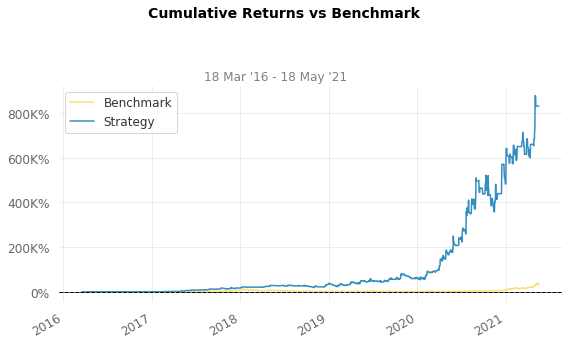

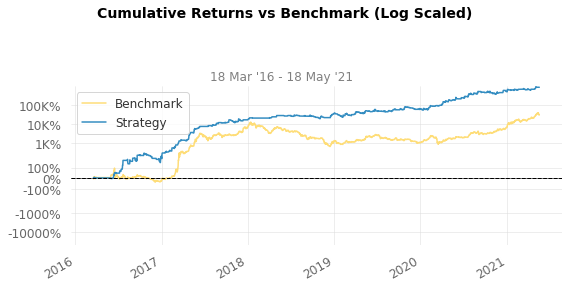

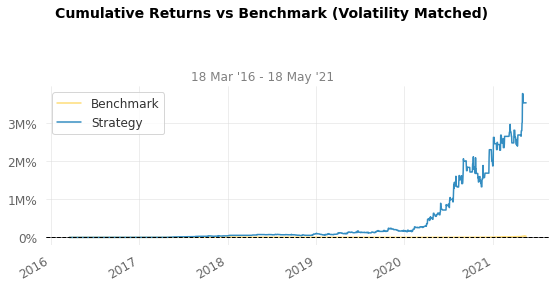

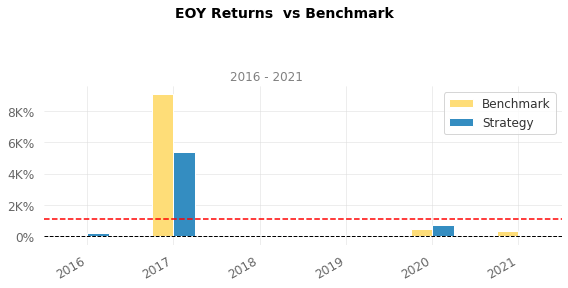

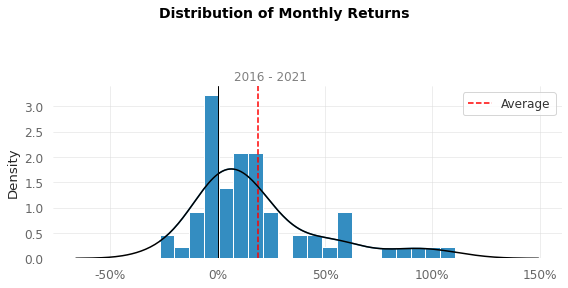

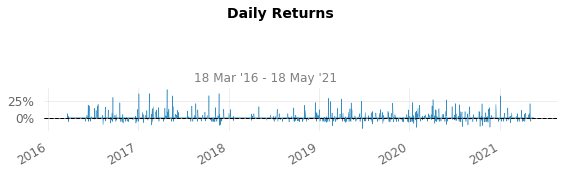

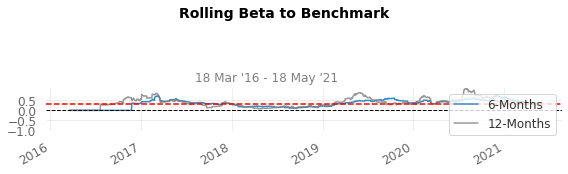

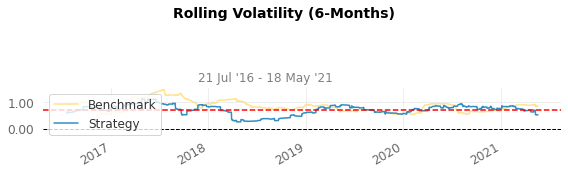

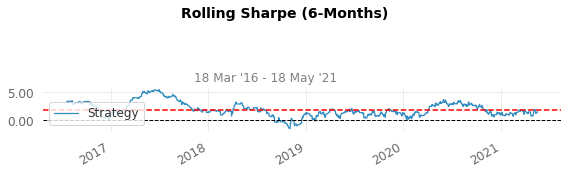

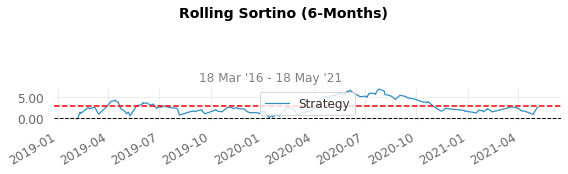

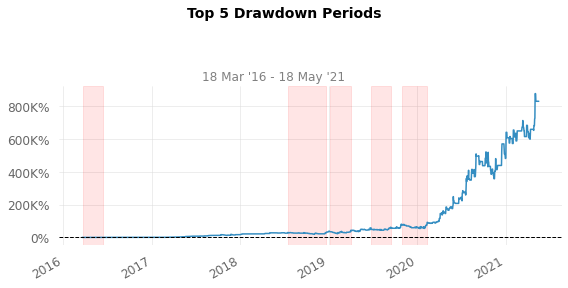

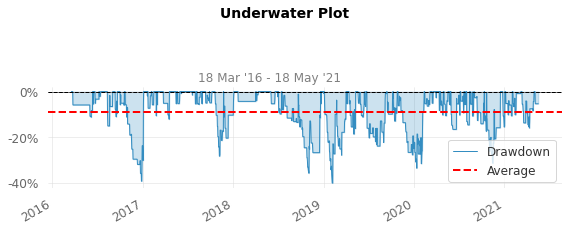

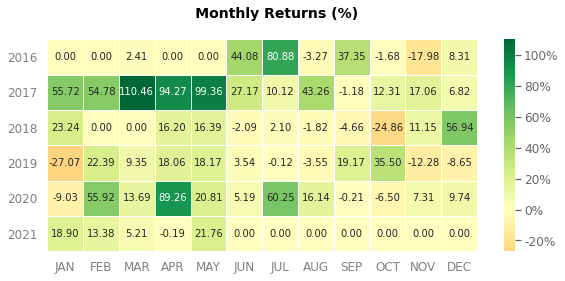

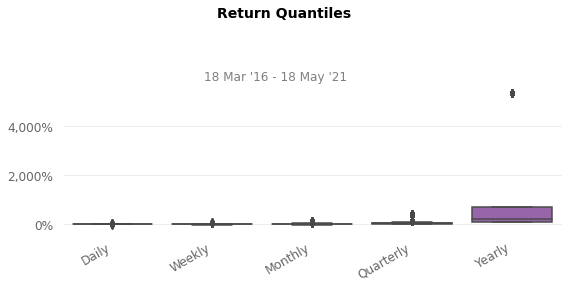

In [42]:
backtest(DEFAULT_CONFIG, "ETHUSD")

backtest completed in 0.09218311309814453 seconds


                           Strategy     Benchmark
-------------------------  -----------  -----------
Start Period               2013-04-09   2013-04-09
End Period                 2021-05-18   2021-05-18
Risk-Free Rate             0.0%         0.0%
Time in Market             33.0%        96.0%

Cumulative Return          692,826.21%  18,597.53%
CAGR%                      197.47%      90.56%

Sharpe                     1.48         0.99
Sortino                    3.32         1.48
Sortino/√2                 2.35         1.04

Max Drawdown               -54.82%      -84.25%
Longest DD Days            283          1126
Volatility (ann.)          63.11%       69.36%
R^2                        0.11         0.11
Calmar                     3.6          1.07
Skew                       4.14         0.14
Kurtosis                   36.23        10.5

Expected Daily %           0.3%         0.18%
Expected Monthly %         9.44%        5.48%
Expected Yearly %          167.14%      78.82%
Kelly Cri

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-07-21,2019-10-19,2020-04-29,283,-54.816135,-52.233434
2,2020-05-01,2020-11-04,2021-01-02,246,-54.272268,-49.346049
3,2014-01-20,2014-05-17,2014-05-30,130,-35.005352,-34.558897
4,2016-10-30,2016-11-30,2016-12-27,58,-31.291253,-30.982330
5,2016-07-03,2016-09-02,2016-10-27,116,-31.061806,-27.218250


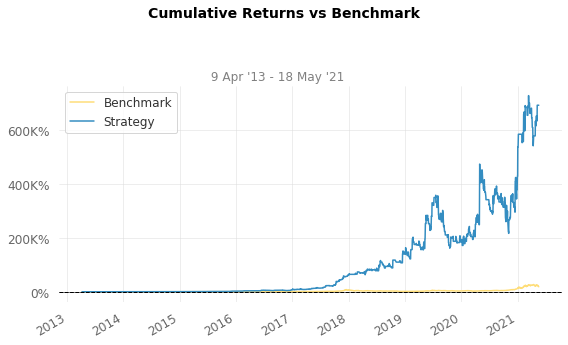

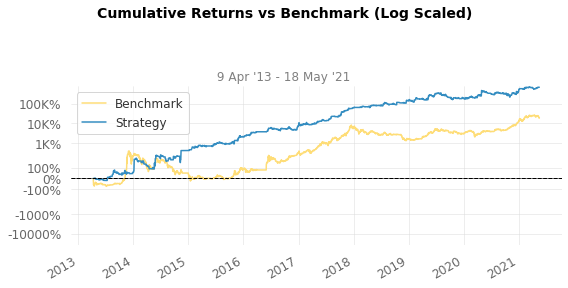

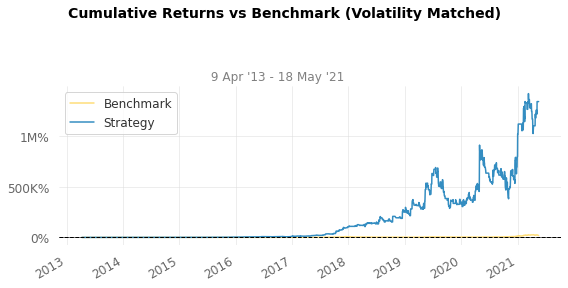

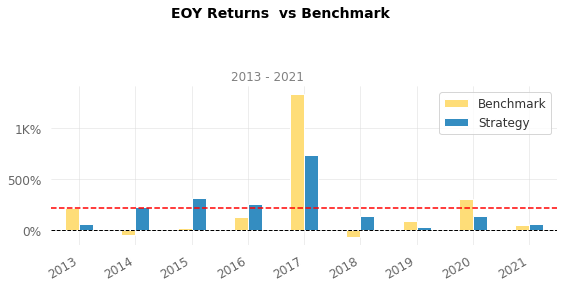

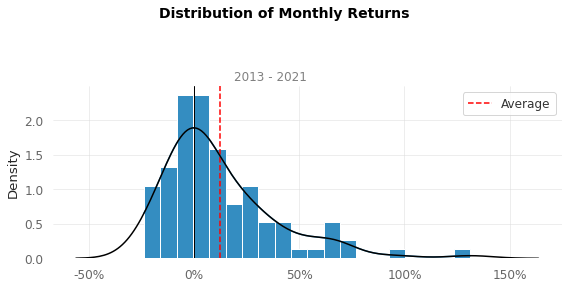

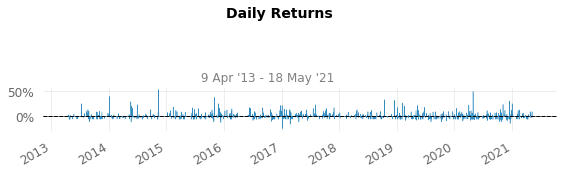

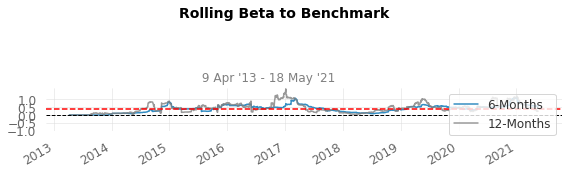

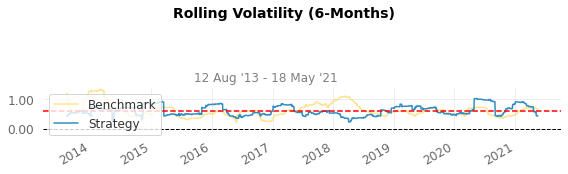

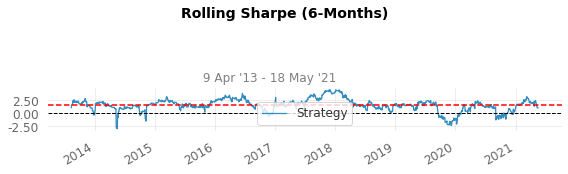

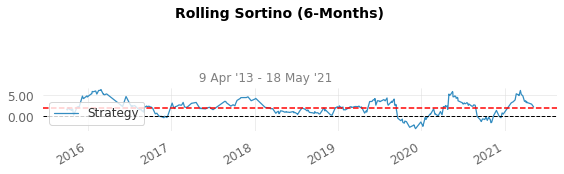

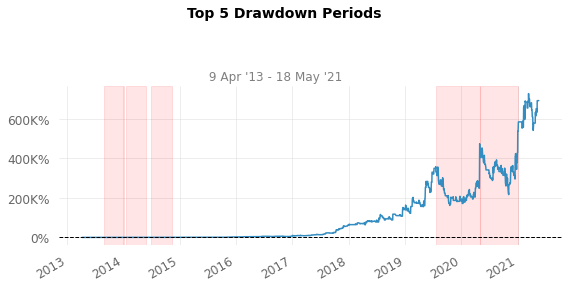

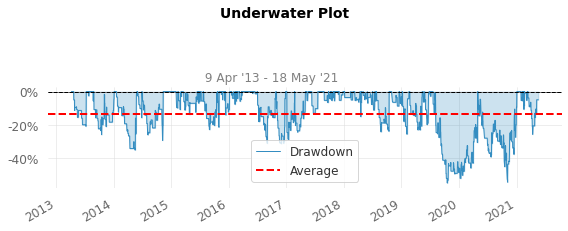

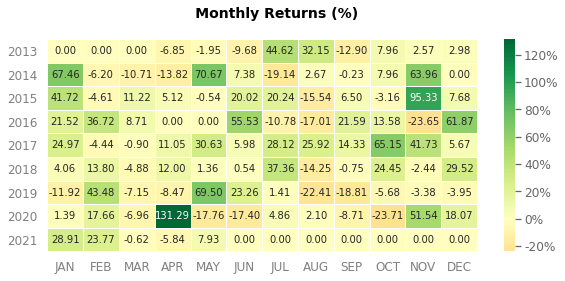

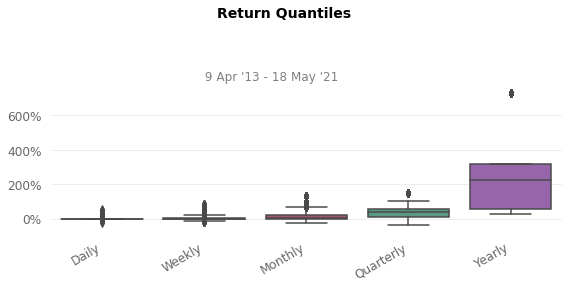

In [43]:
backtest(DEFAULT_CONFIG, "BTCUSD")

In [39]:
import ray
from ray import tune
def optimizer(config, df):
    df = df.copy()
    order_df, port_df = run_backtest_df(strategy(df, config))
    tune.report(sortino=qs.stats.sortino(port_df["portfolio_value"].resample("1D").last()))

def optimize(df):
    result = tune.run(
        tune.with_parameters(optimizer, df=df),
        config = {
            "return_signal_period" : tune.grid_search([12, 24, 48]),
            "ma_period" : tune.grid_search([12, 24, 48]),
            "mean_volume_period" : tune.grid_search([12, 24, 48]),
            "return_period" : tune.grid_search([6, 12, 24]),
            "any_return_period" : 3,
            "time_cut" : tune.grid_search([12, 24]),
            "stop_loss" : tune.grid_search([0.03, 0.05]),
            "take_profit" : tune.grid_search([0.5, 0.1, 0.15]),
            "ma_period" : tune.grid_search([12, 24, 48]),
            "volume_times" : tune.grid_search([3, 5, 7]),
        },
        local_dir="./ray_results",
    )
    return result

/home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


In [8]:
ray.init()

2021-05-25 23:59:39,115	INFO services.py:1269 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.68.106',
 'raylet_ip_address': '192.168.68.106',
 'redis_address': '192.168.68.106:6379',
 'object_store_address': '/tmp/ray/session_2021-05-25_23-59-38_052616_3221/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-05-25_23-59-38_052616_3221/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-05-25_23-59-38_052616_3221',
 'metrics_export_port': 50182,
 'node_id': '2556cecaf15222532a14a4adf3d70c34a3410be1f851a80beb5b3d70'}

In [10]:
data = read_bitfinex_data("/home/ych/Storage/bitfinex/bitfinex.db", "1H", "BTCUSD")
data = data.backtest.add_defaults()

In [11]:
data = data[:int(data.index.__len__() * 0.7)]

In [ ]:
result = optimize(data)

In [13]:
result.get_best_config("sortino", mode="max")

{'return_signal_period': 24,
 'ma_period': 48,
 'mean_volume_period': 12,
 'return_period': 6,
 'any_return_period': 3,
 'time_cut': 24,
 'stop_loss': 0.05,
 'take_profit': 0.15,
 'volume_times': 5}